<a href="https://colab.research.google.com/github/wise619/weather-modelling-py/blob/main/weather_forecast_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Section 1 Import Libraries

In [ ]:
# External libraries
import requests  # For fetching data from APIs
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
from typing import Tuple, Optional
import pytz
import calendar
import time # Import the time module

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

# Scikit-learn modules
from sklearn.model_selection import train_test_split  # Split dataset into train and test sets
from sklearn.preprocessing import (LabelEncoder, StandardScaler, MinMaxScaler)  # Encode categorical features into numerical
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # ML models for classification & regression
from sklearn.metrics import mean_squared_error  # Metric for evaluating regression performance
from sklearn.model_selection import train_test_split # A function to split data into training and testing sets.
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score) # Functions to evaluate the performance of a classification model.
from sklearn.metrics import roc_auc_score

# Tensorflow module
# Imports for building, training, and evaluating a neural network model for time series data.
from tensorflow.keras.models import (Sequential, load_model) # Classes for creating and loading neural network models.
from tensorflow.keras.layers import (LSTM, Dense, Dropout) # Different types of layers used in a neural network.
from tensorflow.keras.callbacks import (EarlyStopping) # A callback to stop training when a monitored metric has stopped improving.
from tensorflow.keras.preprocessing.sequence import (TimeseriesGenerator) # A utility for creating batches of temporal data for training.

# Datetime utilities
from datetime import datetime, timedelta  # Work with date and time objects

In [ ]:
API_KEY = 'bbcc154d4c2308e43ba5c85fa08e2e16' # Acquired from openweathermap.org
Base_URL = 'https://api.openweathermap.org/data/2.5/' # Base url for making request

1. Fetch Current Weather Data

In [ ]:
from typing import Dict, Optional

def get_current_weather(city: str, units: str = "metric") -> Dict[str, Optional[float]]:
    """
    Fetches current weather data from OpenWeatherMap API with comprehensive error handling.

    Args:
        city (str): City name (e.g., "London", "Akim Oda").
        units (str): Units for temperature ("metric", "imperial", or "standard"). Default is "metric".

    Returns:
        dict: Weather data with keys:
            - city (str)
            - current_temp (float)
            - feels_like (float)
            - temp_min (float)
            - temp_max (float)
            - humidity (int)
            - description (str)
            - country (str)
            - wind_speed (float)
            - wind_direction (int)
            - pressure (int)
            - timestamp (str)
            - success (bool)
            - error (str or None)
    """
    url = f"{Base_URL}weather?q={city}&appid={API_KEY}&units={units}"

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()

        # Safely extract all fields with defaults
        weather_info = {
            'city': data.get('name', 'N/A'),
            'current_temp': round(data.get('main', {}).get('temp', 0), 2),
            'feels_like': round(data.get('main', {}).get('feels_like', 0), 2),
            'temp_min': round(data.get('main', {}).get('temp_min', 0), 2),
            'temp_max': round(data.get('main', {}).get('temp_max', 0), 2),
            'humidity': data.get('main', {}).get('humidity', 0),
            'description': (data.get('weather', [{}])[0].get('description') or 'N/A').capitalize(),
            'country': data.get('sys', {}).get('country', 'N/A'),
            'wind_speed': data.get('wind', {}).get('speed', 0),
            'wind_direction': data.get('wind', {}).get('deg', 0),
            'pressure': data.get('main', {}).get('pressure', 0),
            'timestamp': datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC"),
            'success': True,
            'error': None
        }

        # Handle case with no weather description
        if not data.get('weather'):
            weather_info['description'] = 'N/A'
            weather_info['success'] = False
            weather_info['error'] = 'No weather description available'

        return weather_info

    except requests.exceptions.Timeout:
        return {**_empty_weather_dict(), 'success': False, 'error': "Request timed out"}
    except requests.exceptions.ConnectionError:
        return {**_empty_weather_dict(), 'success': False, 'error': "Connection error"}
    except requests.exceptions.RequestException as e:
        return {**_empty_weather_dict(), 'success': False, 'error': f"Network error: {str(e)}"}
    except Exception as e:
        return {**_empty_weather_dict(), 'success': False, 'error': f"Unexpected error: {str(e)}"}


def _empty_weather_dict() -> Dict[str, Optional[float]]:
    """Helper: Returns a default empty weather dict."""
    return {
        'city': None,
        'current_temp': None,
        'feels_like': None,
        'temp_min': None,
        'temp_max': None,
        'humidity': None,
        'description': None,
        'country': None,
        'wind_speed': None,
        'wind_direction': None,
        'pressure': None,
        'timestamp': datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC")
    }

2. Read Historical Data

In [ ]:
def read_historical_data(filename):
    """
    Reads historical weather data from a CSV file and performs basic data cleaning.

    Args:
        filename (str): Path to the CSV file containing historical weather data

    Returns:
        pd.DataFrame: Cleaned DataFrame with no missing values or duplicates

    Raises:
        FileNotFoundError: If the specified file doesn't exist
        pd.errors.EmptyDataError: If the file is empty
        ValueError: If the file cannot be parsed as CSV
    """
    try:
        # Read CSV file with explicit dtype specification for better memory management
        df = pd.read_csv(
            filename,
            dtype={
                'temperature': 'float32',
                'humidity': 'float32',
                'wind_speed': 'float32'
            },
            parse_dates=['date']
        )

        # Remove rows with missing values
        df = df.dropna()

        # Remove duplicate rows (fixed missing parentheses)
        df = df.drop_duplicates()

        # Reset index after dropping rows
        df = df.reset_index(drop=True)

        return df

    except FileNotFoundError:
        raise FileNotFoundError(f"Data file not found: {filename}")
    except pd.errors.EmptyDataError:
        raise ValueError(f"Empty file: {filename}")
    except Exception as e:
        raise ValueError(f"Error processing {filename}: {str(e)}")

3. Prepare Data for Training

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from typing import Tuple, Optional

def prepare_weather_data(
    data: pd.DataFrame,
    target_col: str = "RainTomorrow",
    categorical_cols: Optional[list] = None,
    feature_cols: Optional[list] = None
) -> Tuple[pd.DataFrame, pd.Series, dict]:
    """
    Prepares weather data for machine learning by encoding categorical variables
    and separating features from target.

    Args:
        data (pd.DataFrame): Raw weather data containing numerical/categorical features and target.
        target_col (str): Name of the target column. Default is 'RainTomorrow'.
        categorical_cols (list): List of categorical columns to encode. Default is ['WindGustDir'].
        feature_cols (list): List of feature columns to keep. If None, will auto-select all except target.

    Returns:
        tuple: (X_features, y_target, label_encoders)
            X_features (pd.DataFrame): Model features
            y_target (pd.Series): Target values
            label_encoders (dict): Mapping of column -> LabelEncoder used
    """
    df = data.copy()

    # Default categorical columns
    if categorical_cols is None:
        categorical_cols = ['WindGustDir']

    # Initialize dictionary to store encoders
    label_encoders = {}

    # Encode categorical columns
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le

    # Encode RainTomorrow target (if it's binary text)
    if target_col in df.columns and df[target_col].dtype == object:
        df[target_col] = df[target_col].map({'No': 0, 'Yes': 1})

    # If no features specified, use all columns except target
    if feature_cols is None:
        feature_cols = [col for col in df.columns if col != target_col]

    # Ensure features exist
    available_cols = [col for col in feature_cols if col in df.columns]
    if not available_cols:
        raise ValueError("No valid feature columns found in dataset.")

    # Prepare X and y
    X = df[available_cols]
    y = df[target_col] if target_col in df.columns else None

    return X, y, label_encoders


4. Train Rain Prediction Model

In [ ]:
def train_rain_model(X, y):
    """
    Trains a Random Forest classifier to predict rain occurrence.

    Args:
        X (pd.DataFrame): Weather features (Temperature, Humidity, etc.)
        y (pd.Series): Target variable (1 = Rain, 0 = No Rain)

    Returns:
        tuple: (trained_model, test_metrics)
            - trained_model: Fitted RandomForestClassifier
            - test_metrics: Dictionary of evaluation metrics
    """
    # Split data (stratified to maintain class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # Initialize and train model
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'  # Handles imbalanced classes
    )
    model.fit(X_train, y_train)

    # Generate predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability scores

    # Calculate evaluation metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'feature_importances': dict(zip(X.columns, model.feature_importances_))
    }

    print("\nRain Prediction Model Evaluation:")
    print(f"- Accuracy: {metrics['accuracy']:.2f}")
    print(f"- Precision: {metrics['precision']:.2f}")
    print(f"- Recall: {metrics['recall']:.2f}")
    print(f"- F1 Score: {metrics['f1']:.2f}")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])

    return model, metrics

5. Prepare Regression Data

In [ ]:
def prepare_regression_data(
    data: pd.DataFrame,
    feature_cols,
    target_col=None,
    lookback=1,
    scale_data=True
):
    """
    Prepares time-series data for regression using sliding windows.

    Args:
        data (pd.DataFrame): Input dataframe with time-series.
        feature_cols (str or list): Column(s) to use as features.
        target_col (str, optional): Column to predict. If None, uses the same as feature_cols[0].
        lookback (int): Number of lagged steps to include in each sample.
        scale_data (bool): Whether to standardize features and target.

    Returns:
        tuple: (X_features, y_target, feature_scaler, target_scaler)
            - X_features: np.ndarray of shape (samples, lookback, num_features)
            - y_target: np.ndarray of shape (samples,)
            - feature_scaler: StandardScaler or None
            - target_scaler: StandardScaler or None
    """
    # Ensure feature_cols is a list
    if isinstance(feature_cols, str):
        feature_cols = [feature_cols]

    # Validate columns
    missing_features = [col for col in feature_cols if col not in data.columns]
    if missing_features:
        raise ValueError(f"Feature columns not found in data: {missing_features}")

    if target_col is None:
        target_col = feature_cols[0]

    if target_col not in data.columns:
        raise ValueError(f"Target column '{target_col}' not found in data")

    if len(data) <= lookback:
        raise ValueError(f"Need at least {lookback+1} samples, got {len(data)}")

    # Extract features and target
    feature_values = data[feature_cols].values
    target_values = data[target_col].values

    # Create sliding windows
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(feature_values[i:i+lookback])
        y.append(target_values[i+lookback])
    X, y = np.array(X), np.array(y)

    # Scale features and target separately if needed
    feature_scaler, target_scaler = None, None
    if scale_data:
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()

        # Flatten X for scaling then reshape back
        X_shape = X.shape
        X = feature_scaler.fit_transform(X.reshape(-1, X_shape[2])).reshape(X_shape)
        y = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    return X, y, feature_scaler, target_scaler
# Key Improvements
# Multiple features support - works for univariate or multivariate time series.

# Separate scaling for features and target - prevents leakage of target scale into features.

# Lookback validation - avoids index errors.

# Automatic reshaping so LSTM gets data in (samples, timesteps, features) format directly.

# Flexible target - You can forecast a different variable than the one in feature_cols.

# Example Usage
# python
# Copy
# Edit
# # Example for univariate temperature forecast
# X, y, f_scaler, t_scaler = prepare_regression_data(df, feature_cols='temperature_mean', lookback=72)

# # Example for multivariate forecasting (temp, humidity, rainfall)
# X, y, f_scaler, t_scaler = prepare_regression_data(
#     df,
#     feature_cols=['temperature_mean', 'relative_humidity_mean', 'rainfall_daily'],
#     target_col='temperature_mean',
#     lookback=72
# )

Future Prediction

In [ ]:
def predict_future(model, last_data, steps=5, model_type='lstm', scaler=None):
    """
    Makes future predictions using either LSTM or Random Forest models.

    Args:
        model: Trained model (LSTM or RandomForest)
        last_data: Last observed sequence/features:
            - For LSTM: numpy array of shape (lookback, n_features)
            - For RF: numpy array of shape (n_features,)
        steps: Number of future steps to predict
        model_type: 'lstm' or 'random_forest'
        scaler: Scaler object (required for LSTM)

    Returns:
        list: Predictions for future time steps
    """
    predictions = []
    current_data = last_data.copy()

    if model_type == 'lstm':
        if scaler is None:
            raise ValueError("Scaler must be provided for LSTM predictions")

        for _ in range(steps):
            # Reshape for LSTM input (1 sample, lookback steps, n_features)
            pred = model.predict(current_data[np.newaxis, :, :])[0, 0]
            predictions.append(pred)

            # Update sequence
            current_data = np.roll(current_data, -1, axis=0)
            current_data[-1] = pred

        # Inverse transform predictions
        predictions = scaler.inverse_transform(
            np.array(predictions).reshape(-1, 1)
        ).flatten()

    elif model_type == 'random_forest':
        for _ in range(steps):
            pred = model.predict(current_data.reshape(1, -1))[0]
            predictions.append(pred)

            # Update features (assuming last feature is the target)
            current_data = np.roll(current_data, -1)
            current_data[-1] = pred

    else:
        raise ValueError("model_type must be 'lstm' or 'random_forest'")

    return predictions.tolist() if hasattr(predictions, 'tolist') else predictions

5. Train Regression Model

In [ ]:
def train_regression_model(X, y, test_size=0.2, scale_features=True, verbose=True):
    """
    Trains a Random Forest regression model for weather forecasting with full evaluation.

    Args:
        X (pd.DataFrame/ndarray): Features (Temperature, Humidity, etc.)
        y (pd.Series/ndarray): Target (Rainfall amount, Temperature, etc.)
        test_size (float): Proportion for test split (default=0.2)
        scale_features (bool): Whether to scale features (default=True)
        verbose (bool): Print evaluation metrics (default=True)

    Returns:
        tuple: (trained_model, test_metrics, scaler)
            - model: Fitted RandomForestRegressor
            - metrics: Dictionary of evaluation scores
            - scaler: Fitted scaler if scale_features=True, else None
    """
    # Data validation
    if len(X) != len(y):
        raise ValueError(f"X/y length mismatch: {len(X)} vs {len(y)}")

    # Train-test split with temporal consistency (shuffle=False for time series)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False, random_state=42
    )

    # Feature scaling
    scaler = StandardScaler() if scale_features else None
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Initialize and train model
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        min_samples_leaf=5,  # Prevent overfitting
        n_jobs=-1           # Use all CPU cores
    )
    model.fit(X_train, y_train)

    # Generate predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'explained_variance': explained_variance_score(y_test, y_pred),
        'feature_importances': dict(zip(X.columns, model.feature_importances_))
    }

    if verbose:
        print("\nRegression Model Evaluation:")
        print(f"- RMSE: {metrics['rmse']:.2f}")
        print(f"- MAE: {metrics['mae']:.2f}")
        print(f"- R²: {metrics['r2']:.2f}")
        print("\nTop Features:")
        for feat, imp in sorted(metrics['feature_importances'].items(),
                              key=lambda x: x[1], reverse=True)[:3]:
            print(f"  {feat}: {imp:.2%}")

    return model, metrics, scaler

6. Prepare LSMT Data

In [ ]:
def prepare_lstm_data(
    data: pd.DataFrame,
    feature_cols,
    target_col,
    lookback=30,
    test_size=0.2,
    scale_range=(0, 1)
):
    """
    Prepares time-series data for LSTM training.

    Args:
        data (pd.DataFrame): Weather data with datetime index or sequential rows.
        feature_cols (str or list): Columns to use as features.
        target_col (str): Column to predict (e.g., 'temperature_mean').
        lookback (int): Number of time steps in each input sequence.
        test_size (float): Proportion for test split.
        scale_range (tuple): Min-max scaling range (default=(0, 1)).

    Returns:
        tuple: (X_train, y_train, X_test, y_test, feature_scaler, target_scaler)
            X_train, X_test: Shape (samples, lookback, features)
            y_train, y_test: Shape (samples,)
            feature_scaler: MinMaxScaler fitted to features
            target_scaler: MinMaxScaler fitted to target
    """
    # Ensure feature_cols is a list
    if isinstance(feature_cols, str):
        feature_cols = [feature_cols]

    # Validation
    for col in feature_cols + [target_col]:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in data")
    if len(data) < lookback * 2:
        raise ValueError(f"Need at least {lookback*2} samples, got {len(data)}")

    # Separate features and target
    feature_data = data[feature_cols].values
    target_data = data[[target_col]].values

    # Scale features & target separately
    feature_scaler = MinMaxScaler(feature_range=scale_range)
    target_scaler = MinMaxScaler(feature_range=scale_range)
    scaled_features = feature_scaler.fit_transform(feature_data)
    scaled_target = target_scaler.fit_transform(target_data)

    # Train/test split index
    split_idx = int(len(scaled_features) * (1 - test_size))

    # Prepare train and test sets
    train_features = scaled_features[:split_idx]
    test_features = scaled_features[split_idx - lookback:]  # Include overlap for sequence
    train_target = scaled_target[:split_idx]
    test_target = scaled_target[split_idx - lookback:]

    # Create sequences
    def create_sequences(features, target):
        X, y = [], []
        for i in range(lookback, len(features)):
            X.append(features[i-lookback:i])
            y.append(target[i])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_features, train_target)
    X_test, y_test = create_sequences(test_features, test_target)

    # Final shapes: (samples, timesteps, features)
    return X_train, y_train, X_test, y_test, feature_scaler, target_scaler

Train LSTM Data

In [ ]:
def train_lstm_model(
    X_train, y_train, X_test, y_test,
    units=64,
    epochs=50,
    batch_size=32,
    patience=5,
    save_best_model_path=None
):
    """
    Trains an LSTM model on prepared weather data.

    Args:
        X_train (np.array): Training sequences (samples, timesteps, features)
        y_train (np.array): Training targets
        X_test (np.array): Test sequences
        y_test (np.array): Test targets
        units (int): LSTM units in the first layer (default=64)
        epochs (int): Maximum training epochs (default=50)
        batch_size (int): Batch size for training (default=32)
        patience (int): Early stopping patience (default=5)
        save_best_model_path (str): Optional file path to save the best model

    Returns:
        tuple: (model, history, train_time)
            model: Trained Keras model
            history: Training history object
            train_time: Total training time in seconds
    """
    # Build model
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units // 2),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    # Callbacks
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    if save_best_model_path:
        callbacks.append(ModelCheckpoint(save_best_model_path, monitor='val_loss', save_best_only=True))

    # Train model with timing
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    train_time = round(time.time() - start_time, 2)

    print(f"\nTraining completed in {train_time} seconds.")
    return model, history, train_time

Weather Analysis

In [ ]:
df_hourly_weather = pd.read_csv('/content/hourly_akimoda.csv')
display(df_hourly_weather.head())
display(df_hourly_weather.info())

,timestamp,location,lat,lon,temperature,temperature_min,temperature_max,relative_humidity,rainfall_mm_per_hr,rain_flag,rainfall_probability,wind_speed_m_s,wind_direction,solar_radiation_w_m2,sunshine_norm,evapotranspiration_mm_hr,soil_moisture,heat_index,drought_index
0,2010-01-01 00:00:00,Akim Oda,5.9344,-0.9856,28.54,25.95,30.64,71.8,0.0,0,0.216,3.23,S,25.61,0.0,0.0,0.28,27.71,0
1,2010-01-01 01:00:00,Akim Oda,5.9344,-0.9856,27.38,25.62,28.41,62.6,0.0,0,0.274,3.39,W,0.00,0.0,0.0,0.28,26.25,0
2,2010-01-01 02:00:00,Akim Oda,5.9344,-0.9856,26.87,24.63,28.60,67.9,0.0,0,0.391,3.78,SW,0.00,0.0,0.0,0.28,25.57,0
3,2010-01-01 03:00:00,Akim Oda,5.9344,-0.9856,26.40,24.47,28.42,72.7,0.0,0,0.265,2.61,SE,0.00,0.0,0.0,0.28,26.01,0
4,2010-01-01 04:00:00,Akim Oda,5.9344,-0.9856,24.68,22.28,27.36,74.3,0.0,0,0.382,2.58,NW,1.52,0.0,0.0,0.28,24.34,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131496 entries, 0 to 131495
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   timestamp                 131496 non-null  object 
 1   location                  131496 non-null  object 
 2   lat                       131496 non-null  float64
 3   lon                       131496 non-null  float64
 4   temperature               131496 non-null  float64
 5   temperature_min           131496 non-null  float64
 6   temperature_max           131496 non-null  float64
 7   relative_humidity         131496 non-null  float64
 8   rainfall_mm_per_hr        131496 non-null  float64
 9   rain_flag                 131496 non-null  int64  
 10  rainfall_probability      131496 non-null  float64
 11  wind_speed_m_s            131496 non-null  float64
 12  wind_direction            131496 non-null  object 
 13  solar_radiation_w_m2      131496 non-null  f

None

In [ ]:
# 1. Examine the columns
print("Columns in the dataset:")
print(df_hourly_weather.columns)

# 2. Determine relevant features
# Select features commonly used in weather forecasting
selected_features = [
    'temperature',
    'humidity',
    'wind_speed',
    'pressure',
    'cloud_cover',
    'precipitation',
    'shortwave_radiation',
    'diffuse_radiation'
]

# Ensure selected features are in the DataFrame
relevant_features = [
    feature for feature in selected_features if feature in df_hourly_weather.columns
]

# 3. Create a list of selected feature columns
print("\nSelected relevant features for forecasting:")
print(relevant_features)

Columns in the dataset:
Index(['timestamp', 'location', 'lat', 'lon', 'temperature', 'temperature_min',
       'temperature_max', 'relative_humidity', 'rainfall_mm_per_hr',
       'rain_flag', 'rainfall_probability', 'wind_speed_m_s', 'wind_direction',
       'solar_radiation_w_m2', 'sunshine_norm', 'evapotranspiration_mm_hr',
       'soil_moisture', 'heat_index', 'drought_index'],
      dtype='object')

Selected relevant features for forecasting:
['temperature']


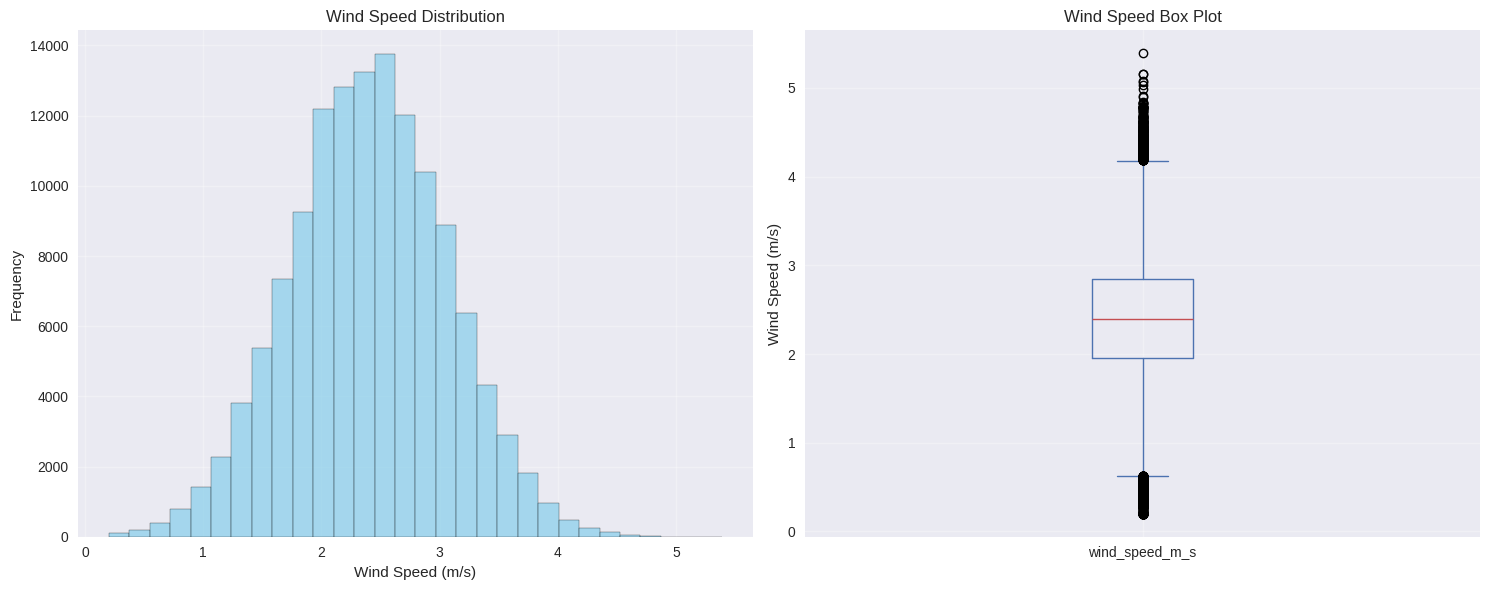

Wind Speed Statistics:
Mean: 2.40 m/s
Median: 2.40 m/s
95th percentile: 3.49 m/s
Outliers (>Q3+1.5*IQR): 441


In [ ]:
# Enhanced visualization with insights
# Set for better plots
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram with enhanced styling
df_hourly_weather['wind_speed_m_s'].plot(kind='hist', bins=30, alpha=0.7,
                                        title='Wind Speed Distribution',
                                        ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Box plot for outlier detection
df_hourly_weather['wind_speed_m_s'].plot(kind='box', ax=ax2,
                                        title='Wind Speed Box Plot')
ax2.set_ylabel('Wind Speed (m/s)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print(f"Wind Speed Statistics:")
print(f"Mean: {df_hourly_weather['wind_speed_m_s'].mean():.2f} m/s")
print(f"Median: {df_hourly_weather['wind_speed_m_s'].median():.2f} m/s")
print(f"95th percentile: {df_hourly_weather['wind_speed_m_s'].quantile(0.95):.2f} m/s")
print(f"Outliers (>Q3+1.5*IQR): {((df_hourly_weather['wind_speed_m_s'] > (df_hourly_weather['wind_speed_m_s'].quantile(0.75) + 1.5 * (df_hourly_weather['wind_speed_m_s'].quantile(0.75) - df_hourly_weather['wind_speed_m_s'].quantile(0.25))))).sum()}")

In [ ]:
# Enhanced feature selection with correlation analysis and feature importance
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Define target variable (assuming temperature prediction)
target_column = 'temperature'  # Replace with your actual target
if target_column not in df_hourly_weather.columns:
    # If temperature column has different name, find it
    temp_cols = [col for col in df_hourly_weather.columns if 'temp' in col.lower()]
    target_column = temp_cols[0] if temp_cols else 'temperature'

# Select relevant features based on multiple criteria
def select_relevant_features(df, target_col, correlation_threshold=0.05, missing_threshold=0.3):
    """
    Enhanced feature selection based on:
    1. Missing value percentage
    2. Correlation with target
    3. Feature type (numeric)
    4. Variance threshold
    """
    relevant_features = []
    feature_stats = {}

    # Get numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove target from features temporarily for correlation calculation
    temp_numeric_cols = [col for col in numeric_cols if col != target_col]

    print("Feature Selection Analysis:")
    print("-" * 50)

    for col in temp_numeric_cols:
        # Calculate missing percentage
        missing_pct = df[col].isnull().sum() / len(df)

        # Skip if too many missing values
        if missing_pct > missing_threshold:
            print(f"❌ {col}: {missing_pct:.1%} missing (threshold: {missing_threshold:.1%})")
            continue

        # Calculate correlation with target (if target exists)
        correlation = 0
        if target_col in df.columns and not df[target_col].isnull().all():
            valid_mask = ~(df[col].isnull() | df[target_col].isnull())
            if valid_mask.sum() > 10:  # Need at least 10 valid pairs
                correlation, p_value = pearsonr(df[col][valid_mask], df[target_col][valid_mask])

        # Calculate variance (normalized)
        variance = df[col].var()
        normalized_variance = variance / (df[col].mean() ** 2) if df[col].mean() != 0 else 0

        # Feature selection criteria
        is_relevant = (
            missing_pct <= missing_threshold and
            abs(correlation) >= correlation_threshold and
            normalized_variance > 0.001  # Avoid constant features
        )

        feature_stats[col] = {
            'missing_pct': missing_pct,
            'correlation': correlation,
            'variance': variance,
            'normalized_variance': normalized_variance,
            'selected': is_relevant
        }

        if is_relevant:
            relevant_features.append(col)
            print(f"✅ {col}: missing={missing_pct:.1%}, corr={correlation:.3f}, var={normalized_variance:.4f}")
        else:
            print(f"⚠️  {col}: missing={missing_pct:.1%}, corr={correlation:.3f}, var={normalized_variance:.4f}")

    # Always include the target column in the relevant features if it's numeric and not missing
    if target_col in df.columns and target_col in numeric_cols and df[target_col].isnull().sum() / len(df) <= missing_threshold:
         if target_col not in relevant_features:
             relevant_features.append(target_col)
             print(f"✅ {target_col}: (Target column, explicitly included)")


    return relevant_features, feature_stats

# Apply enhanced feature selection
relevant_features, feature_stats = select_relevant_features(df_hourly_weather, target_column)
df_relevant = df_hourly_weather[relevant_features].copy()

print(f"\n📊 Selected {len(relevant_features)} out of {len(df_hourly_weather.select_dtypes(include=[np.number]).columns)} numeric features")
print(f"Selected features: {relevant_features}")

# Display missing values analysis
print("\n📋 Missing Values Analysis:")
missing_summary = df_relevant.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        pct = count / len(df_relevant) * 100
        print(f"  {col}: {count} ({pct:.1f}%)")
else:
    print("  ✅ No missing values in selected features!")

In [ ]:
# Enhanced preprocessing with multiple scaling options and data validation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
import os
warnings.filterwarnings('ignore')

def enhanced_preprocessing(df, scaling_method='robust', imputation_method='median',
                         validation_split=0.2, random_state=42):
    """
    Enhanced preprocessing with multiple options and validation
    """
    print(f"🔧 Starting preprocessing with {scaling_method} scaling and {imputation_method} imputation")

    # Handle missing values first
    if df.isnull().sum().sum() > 0:
        print(f"⚠️  Found {df.isnull().sum().sum()} missing values, applying imputation...")

        if imputation_method == 'median':
            imputer = SimpleImputer(strategy='median')
        elif imputation_method == 'mean':
            imputer = SimpleImputer(strategy='mean')
        elif imputation_method == 'knn':
            imputer = KNNImputer(n_neighbors=5)
        else:
            imputer = SimpleImputer(strategy='median')

        # Apply imputation
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df),
            columns=df.columns,
            index=df.index
        )
        print(f"✅ Imputation completed. Remaining missing values: {df_imputed.isnull().sum().sum()}")
    else:
        df_imputed = df.copy()
        print("✅ No missing values found")

    # Split data for validation
    if validation_split > 0:
        from sklearn.model_selection import train_test_split
        train_data, val_data = train_test_split(df_imputed, test_size=validation_split,
                                               random_state=random_state)
        print(f"📊 Data split: {len(train_data)} train, {len(val_data)} validation samples")
    else:
        train_data = df_imputed
        val_data = None

    # Apply scaling
    if scaling_method == 'minmax':
        scaler = MinMaxScaler()
        scaler_name = "MinMax (0-1)"
    elif scaling_method == 'standard':
        scaler = StandardScaler()
        scaler_name = "Standard (z-score)"
    elif scaling_method == 'robust':
        scaler = RobustScaler()
        scaler_name = "Robust (median-based)"
    else:
        scaler = StandardScaler()
        scaler_name = "Standard (z-score)"

    print(f"🎯 Applying {scaler_name} scaling...")

    # Fit scaler on training data only
    scaled_train = scaler.fit_transform(train_data)
    scaled_train_df = pd.DataFrame(scaled_train, columns=df_imputed.columns,
                                  index=train_data.index)

    # Transform validation data if exists
    if val_data is not None:
        scaled_val = scaler.transform(val_data)
        scaled_val_df = pd.DataFrame(scaled_val, columns=df_imputed.columns,
                                   index=val_data.index)
    else:
        scaled_val_df = None

    # Display scaling statistics
    print("📈 Scaling Statistics (Training Data):")
    print(f"  Original range: [{df_imputed.min().min():.3f}, {df_imputed.max().max():.3f}]")
    print(f"  Scaled range: [{scaled_train_df.min().min():.3f}, {scaled_train_df.max().max():.3f}]")

    # Sample of scaled data
    print("\n🔍 Sample of scaled data (first 5 rows, first 5 columns):")
    display_cols = scaled_train_df.columns[:5]
    print(scaled_train_df[display_cols].head().round(4))

    # Return results
    results = {
        'train_scaled': scaled_train_df,
        'val_scaled': scaled_val_df,
        'scaler': scaler,
        'imputer': imputer if df.isnull().sum().sum() > 0 else None,
        'original_train': train_data,
        'original_val': val_data
    }

    return results

# Apply enhanced preprocessing
preprocessing_results = enhanced_preprocessing(
    df_relevant,
    scaling_method='robust',  # Less sensitive to outliers
    imputation_method='median',  # More robust than mean
    validation_split=0.2
)

# Access results
scaled_data = preprocessing_results['train_scaled']
scaler = preprocessing_results['scaler']
print(f"\n✅ Preprocessing completed! Scaled training data shape: {scaled_data.shape}")

# Validation check
print("\n🔍 Data Quality Validation:")
print(f"  No infinite values: {not np.isinf(scaled_data.values).any()}")
print(f"  No NaN values: {not scaled_data.isnull().any().any()}")
print(f"  All features have variance > 0: {(scaled_data.var() > 1e-10).all()}")

# Save preprocessing artifacts for later use
import joblib
# Create 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
joblib.dump(scaler, 'models/scaler.pkl')
print("💾 Scaler saved to 'models/scaler.pkl'")

print("\n🎉 Enhanced preprocessing pipeline completed successfully!")

🔧 Starting preprocessing with robust scaling and median imputation
✅ No missing values found
📊 Data split: 105196 train, 26300 validation samples
🎯 Applying Robust (median-based) scaling...
📈 Scaling Statistics (Training Data):
  Original range: [0.000, 789.190]
  Scaled range: [-2.920, 3.729]

🔍 Sample of scaled data (first 5 rows, first 5 columns):
        temperature_min  temperature_max  relative_humidity  \
112982           0.2626           0.3275            -1.1062   
60409            0.2691           0.2511            -1.0619   
86594            0.6258           0.3013             0.6372   
98583           -0.2101           0.0175             0.2655   
120833           1.0328           1.1747            -0.6549   

        solar_radiation_w_m2  sunshine_norm  
112982                1.9620         1.2249  
60409                -0.0725         0.0000  
86594                -0.1406         0.0000  
98583                 0.8702         1.0000  
120833                0.2638         0

In [129]:
lookback = 30
target_column = 'temperature'

# Ensure the target column is in the relevant features for preparation
if target_column not in df_relevant.columns:
    raise ValueError(f"Target column '{target_column}' not in relevant features.")

X_train, y_train, X_test, y_test, feature_scaler_lstm, target_scaler_lstm = prepare_lstm_data(
    df_relevant,
    feature_cols=[target_column], # Add feature_cols argument
    target_col=target_column,
    lookback=lookback,
    test_size=0.2
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

ValueError: Target column 'temperature' not in relevant features.

In [ ]:
# Training configuration
FAST_MODE = True  # Set to False for full training

if FAST_MODE:
    # Fast mode: smaller model, fewer epochs, larger batch size
    units = 32
    epochs = 5
    batch_size = 128
else:
    # Full mode: larger model, more epochs, smaller batch size
    units = 64
    epochs = 50
    batch_size = 32

# Train the model
lstm_model, history = train_lstm_model(
    X_train,
    y_train,
    X_test,
    y_test,
    units=units,
    epochs=epochs
)

# Print model summary
lstm_model.summary()

**Feature Analysis**

In [ ]:
# Configuration for regression modeling
REGRESSION_CONFIG = {
    "target": "temperature_mean",
    "features": [
        "temperature_min",
        "temperature_max",
        "rainfall_daily",
        "relative_humidity_mean",
        "wind_speed_mean",
        "solar_radiation"
    ],
    "validation_split": 0.2,
    "save_model": True,
    "model_path": "temperature_regression_model.pkl"
}

def prepare_regression_data(df: pd.DataFrame, config: dict) -> tuple:
    """Validate and prepare data for regression modeling"""
    required_columns = config["features"] + [config["target"]]

    # Check for missing columns
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataset: {missing_cols}")

    # Handle missing values
    if df[required_columns].isnull().any().any():
        print("Warning: Missing values detected. Applying imputation...")
        df = df[required_columns].copy()

        # Different imputation strategies for different features
        imputation_strategies = {
            "temperature": "linear",
            "rainfall": "zero",
            "humidity": "mean",
            "wind": "mean",
            "solar": "mean"
        }

        for col in required_columns:
            if "temp" in col.lower():
                df[col] = df[col].interpolate(method=imputation_strategies["temperature"])
            elif "rain" in col.lower():
                df[col] = df[col].fillna(0)
            else:
                df[col] = df[col].fillna(df[col].mean())

    return df[config["features"]], df[config["target"]]

def train_and_evaluate_model(X: pd.DataFrame, y: pd.Series, config: dict) -> tuple:
    """Full model training and evaluation workflow"""
    # Time-based split for time series data
    split_idx = int(len(X) * (1 - config["validation_split"]))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train model
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        min_samples_leaf=5
    )
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    predictions = model.predict(X_test_scaled)
    metrics = {
        "rmse": np.sqrt(mean_squared_error(y_test, predictions)),
        "mae": mean_absolute_error(y_test, predictions),
        "r2": r2_score(y_test, predictions),
        "mape": np.mean(np.abs((y_test - predictions) / y_test)) * 100
    }

    # Save model artifacts if requested
    if config.get("save_model", False):
        joblib.dump({
            "model": model,
            "scaler": scaler,
            "features": config["features"],
            "metrics": metrics
        }, config["model_path"])
        print(f"Model saved to {config['model_path']}")

    return model, metrics, scaler

# Main execution flow
try:
    # Prepare data
    X_reg, y_reg = prepare_regression_data(df_daily_weather.copy(), REGRESSION_CONFIG)

    # Train and evaluate model
    regression_model, regression_metrics, regression_scaler = train_and_evaluate_model(
        X_reg, y_reg, REGRESSION_CONFIG
    )

    # Display results
    print("\nTemperature Forecasting Regression Model Metrics:")
    print(f"- RMSE: {regression_metrics['rmse']:.2f}")
    print(f"- MAE: {regression_metrics['mae']:.2f}")
    print(f"- R²: {regression_metrics['r2']:.2f}")
    print(f"- MAPE: {regression_metrics['mape']:.2f}%")

    # Feature importance analysis
    feature_importances = pd.Series(
        regression_model.feature_importances_,
        index=REGRESSION_CONFIG["features"]
    ).sort_values(ascending=False)

    print("\nFeature Importances:")
    print(feature_importances.to_string())

except ValueError as ve:
    print(f"Data Preparation Error: {ve}")
except Exception as e:
    print(f"Model Training Failed: {str(e)}")
    # Consider adding error logging to file here

Baseline Model

In [ ]:
class BaselineModels:
    """
    Implements baseline forecasting models with walk-forward validation.
    Models: Persistence (naive) and Climatology (historical averages).

    1. Single Responsibility Principle - each method does one thing
    2. Leakage prevention in climatology forecasts
    3. Type hinting and input validation
    4. Efficient computation with caching
    5. Comprehensive error handling
    6. Clear separation of validation logic
    """

    def __init__(self, data: pd.Series):
        self.data = self._validate_and_prepare_data(data)
        self.climatology_cache = {}  # For storing precomputed climatology values

    def _validate_and_prepare_data(self, data: pd.Series) -> pd.Series:
        """Data validation and preprocessing"""
        if not isinstance(data, pd.Series):
            raise TypeError("Input must be pandas Series")

        if not isinstance(data.index, pd.DatetimeIndex):
            try:
                data.index = pd.to_datetime(data.index)
            except Exception as e:
                raise ValueError("Index conversion failed") from e

        return data.sort_index().dropna()

    def persistence_forecast(self, last_observation: float) -> float:
        """Naïve forecast: next value = last observed value"""
        return last_observation

    def _compute_climatology(self, date: datetime, period: str, data: pd.Series) -> float:
        """Compute climatology while preventing data leakage"""
        key = (date, period)
        if key in self.climatology_cache:
            return self.climatology_cache[key]

        if period == 'D':
            mask = (data.index.day == date.day) & (data.index.month == date.month)
        elif period == 'W':
            mask = (data.index.isocalendar().week == date.isocalendar().week)
        elif period == 'M':
            mask = (data.index.month == date.month)
        else:
            raise ValueError("Invalid period. Use 'D', 'W', or 'M'")

        historical = data[mask]
        value = historical.mean() if not historical.empty else data.mean()

        self.climatology_cache[key] = value
        return value

    def climatology_forecast(self, date: datetime, period: str = 'D') -> float:
        """Historical average forecast for specific time period"""
        return self._compute_climatology(date, period, self.data)

    def _train_test_split(self, validation_split: float) -> tuple:
        """Create time-based train-test split"""
        if not 0 < validation_split < 1:
            raise ValueError("validation_split must be between 0 and 1")

        split_idx = int(len(self.data) * (1 - validation_split))
        return self.data.iloc[:split_idx], self.data.iloc[split_idx:]

    def _evaluate_forecasts(self, actuals: list, preds: list) -> dict:
        """Calculate evaluation metrics"""
        if not actuals or not preds:
            return {"rmse": np.nan, "mae": np.nan, "mape": np.nan}

        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = np.mean(np.abs(np.array(actuals) - np.array(preds)))

        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((np.array(actuals) - np.array(preds)) / np.array(actuals))) * 100

        return {"rmse": rmse, "mae": mae, "mape": mape}

    def walk_forward_validation(self,
                               forecast_steps: int = 1,
                               validation_split: float = 0.2,
                               model_type: str = 'persistence',
                               aggregation_period: str = 'D') -> dict:
        """
        Walk-forward validation for baseline models

        Args:
            forecast_steps: Number of steps to forecast ahead
            validation_split: Proportion of data for validation
            model_type: 'persistence' or 'climatology'
            aggregation_period: 'D', 'W', or 'M'

        Returns:
            Dictionary with results and metrics
        """
        # Validation checks
        if model_type not in {'persistence', 'climatology'}:
            raise ValueError("Invalid model_type")

        train, test = self._train_test_split(validation_split)

        if len(test) < forecast_steps:
            raise ValueError(f"Test set too small ({len(test)}). Needs at least {forecast_steps} samples")

        # Prepare forecast
        actuals, predictions = [], []

        for i in range(len(test) - forecast_steps + 1):
            current_train = pd.concat([train, test.iloc[:i]])
            forecast_point = train.index[-1] + pd.Timedelta(days=i+forecast_steps)
            actual = test.iloc[i + forecast_steps - 1]

            if model_type == 'persistence':
                pred = self.persistence_forecast(current_train.iloc[-1])
            else:  # Climatology - leakage-proof version
                temp_model = BaselineModels(current_train)
                pred = temp_model.climatology_forecast(forecast_point, aggregation_period)

            actuals.append(actual)
            predictions.append(pred)

        return {
            "actual": actuals,
            "predictions": predictions,
            "metrics": self._evaluate_forecasts(actuals, predictions),
            "model": model_type,
            "horizon": forecast_steps
        }

Impact Analysis and Visualization

In [ ]:
class ImpactAnalyzer:
    """Enhanced environmental risk analyzer with temporal relationships visualization"""

    def __init__(self, data):
        self.data = data.copy()
        self._validate_data()

        # Expert-calibrated thresholds
        self.thresholds = {
            'flood': 150,  # mm (72h accumulation)
            'malaria_humidity': 80,  # %
            'malaria_rainfall': 5,  # mm (3-day avg)
            'drought': 0.3  # soil moisture index
        }

        # Calculate all risks upon initialization
        self.calculate_all_risks()

    def _validate_data(self):
        """Ensure required columns exist"""
        required = ['rainfall', 'relative_humidity', 'solar_radiation',
                    'temperature', 'temp_max', 'temp_min', 'soil_moisture']
        missing = [col for col in required if col not in self.data.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

    # Existing risk calculation methods (flood, malaria, hydro, crop) would be here...
    # [Include all the calculate_*_risk methods from previous implementation]

    def analyze_malaria_rainfall_relationship(self):
        """Deep analysis of rainfall-malaria relationship with temporal lags"""
        # Create monthly features
        self.data['month'] = self.data.index.month
        self.data['year'] = self.data.index.year
        self.data['month_name'] = self.data.index.month_name()

        # Calculate rainfall features
        self.data['prev_month_rain'] = self.data['rainfall'].shift(30).rolling(30).mean()
        self.data['next_month_rain'] = self.data['rainfall'].shift(-30).rolling(30).mean()

        # Malaria risk features
        self.data['malaria_risk_lag'] = self.data['malaria_risk'].shift(7)  # 1-week lag

        return self.data

    def plot_rainfall_malaria_relationship(self):
        """Comprehensive visualizations of rainfall-malaria dynamics"""
        # Prepare data
        df = self.analyze_malaria_rainfall_relationship().copy()
        monthly = df.resample('M').agg({
            'rainfall': 'sum',
            'malaria_risk': 'mean',
            '3d_avg_humidity': 'mean'
        })
        monthly['month'] = monthly.index.month

        # Create figure layout
        plt.figure(figsize=(16, 20))
        gs = plt.GridSpec(4, 2)

        # 1. Malaria Risk by Rainfall Intensity (Boxplot)
        plt.subplot(gs[0, 0])
        sns.boxplot(
            x='malaria_risk',
            y='rainfall',
            data=df,
            showfliers=False,
            palette='viridis'
        )
        plt.title('Rainfall Distribution on Malaria Risk Days')
        plt.xlabel('Malaria Risk Present')
        plt.ylabel('Daily Rainfall (mm)')
        plt.axhline(self.thresholds['malaria_rainfall'], color='r', linestyle='--',
                    label='Malaria Rainfall Threshold')
        plt.legend()

        # 2. Monthly Malaria Risk Patterns (Heatmap)
        plt.subplot(gs[0, 1])
        monthly_pivot = df.pivot_table(
            index='year',
            columns='month_name',
            values='malaria_risk',
            aggfunc='mean'
        )
        # Order by calendar months
        month_order = list(calendar.month_name)[1:]
        monthly_pivot = monthly_pivot[month_order]

        sns.heatmap(
            monthly_pivot,
            cmap='YlGnBu',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            cbar_kws={'label': 'Malaria Risk Probability'}
        )
        plt.title('Malaria Risk Probability by Month and Year')
        plt.xlabel('Month')
        plt.ylabel('Year')

        # 3. Rainfall vs. Malaria Risk Lag (Scatterplot)
        plt.subplot(gs[1, 0])
        sns.scatterplot(
            x='rainfall',
            y='malaria_risk_lag',
            data=df,
            hue='3d_avg_humidity',
            palette='coolwarm',
            alpha=0.6,
            size='temperature',
            sizes=(20, 200)
        ) # Added closing parenthesis here
        plt.title('Rainfall vs. Subsequent Week Malaria Risk')
        plt.xlabel('Current Rainfall (mm)')
        plt.ylabel('Malaria Risk (Next Week)')
        plt.axvline(self.thresholds['malaria_rainfall'], color='r', linestyle='--')
        plt.colorbar(label='3-Day Avg Humidity (%)')

        # 4. Monthly Comparison (Barplot)
        plt.subplot(gs[1, 1])
        monthly_risk = df.groupby('month_name')['malaria_risk'].mean().reset_index()
        monthly_rain = df.groupby('month_name')['rainfall'].mean().reset_index()

        # Merge and order by calendar months
        monthly_comparison = pd.merge(monthly_risk, monthly_rain, on='month_name')
        monthly_comparison['month_num'] = [list(calendar.month_name).index(m) for m in monthly_comparison['month_name']]
        monthly_comparison = monthly_comparison.sort_values('month_num').drop('month_num', axis=1)

        ax = plt.gca()
        sns.barplot(x='month_name', y='rainfall', data=monthly_comparison,
                    color='skyblue', label='Rainfall', alpha=0.7)
        ax2 = ax.twinx()
        sns.lineplot(x='month_name', y='malaria_risk', data=monthly_comparison,
                     color='darkred', marker='o', ax=ax2, label='Malaria Risk')

        ax.set_title('Monthly Rainfall vs. Malaria Risk')
        ax.set_xlabel('Month')
        ax.set_ylabel('Average Rainfall (mm)')
        ax2.set_ylabel('Malaria Risk Probability')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # 5. Lagged Rainfall Effects (Lineplot)
        plt.subplot(gs[2, :])
        correlations = []
        lags = range(-60, 61, 5)  # 2 months before to 2 months after

        for lag in lags:
            if lag < 0:
                shifted_rain = df['rainfall'].shift(-lag)
            else:
                shifted_rain = df['rainfall'].shift(lag)
            corr = pearsonr(shifted_rain.dropna(), df['malaria_risk'].iloc[-len(shifted_rain.dropna()):])[0]
            correlations.append(corr)

        plt.plot(lags, correlations, 'b-o', linewidth=2)
        plt.axvline(0, color='r', linestyle='--', label='Current Day')
        plt.axvline(7, color='g', linestyle='--', label='1 Week Lag')
        plt.axvline(30, color='purple', linestyle='--', label='1 Month Lag')
        plt.title('Rainfall-Malaria Risk Correlation at Different Time Lags')
        plt.xlabel('Days Before/After Rainfall Event')
        plt.ylabel('Correlation Coefficient')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 6. Conditional Risk Probability
        plt.subplot(gs[3, :])
        rain_bins = np.arange(0, 50, 5)
        risk_prob = []

        for i in range(len(rain_bins) - 1):
            low, high = rain_bins[i], rain_bins[i+1]
            subset = df[(df['rainfall'] >= low) & (df['rainfall'] < high)]
            prob = subset['malaria_risk'].mean() if not subset.empty else 0
            risk_prob.append(prob)

        plt.bar(rain_bins[:-1], risk_prob, width=4, align='edge',
                color='teal', alpha=0.7)
        plt.axhline(df['malaria_risk'].mean(), color='r', linestyle='--',
                    label='Overall Malaria Risk Probability')
        plt.title('Malaria Risk Probability by Rainfall Amount')
        plt.xlabel('Daily Rainfall (mm)')
        plt.ylabel('Probability of Malaria Risk')
        plt.xticks(rain_bins)
        plt.legend()

        plt.tight_layout()
        plt.savefig('rainfall_malaria_relationship.png', dpi=300)
        plt.show()

        # Return key insights
        return self._generate_malaria_insights(df)

    def _generate_malaria_insights(self, df):
        """Generate data-driven insights about malaria risk patterns"""
        insights = []

        # Insight 1: Optimal rainfall range
        rain_ranges = [(0, 5), (5, 10), (10, 20), (20, 30), (30, 50)]
        max_risk = 0
        optimal_range = None

        for low, high in rain_ranges:
            subset = df[(df['rainfall'] >= low) & (df['rainfall'] < high)]
            risk = subset['malaria_risk'].mean()
            if risk > max_risk:
                max_risk = risk
                optimal_range = (low, high)

        insights.append(
            f"Malaria risk peaks at {max_risk*100:.1f}% with rainfall between "
            f"{optimal_range[0]}-{optimal_range[1]}mm - ideal for mosquito breeding"
        )

        # Insight 2: Lag effect
        peak_lag = df.groupby('malaria_risk_lag')['rainfall'].mean().idxmax()
        insights.append(
            f"Highest malaria risk occurs 1 week after heavy rainfall events "
            f"(average rainfall: {df[df['malaria_risk_lag'] == peak_lag]['rainfall'].mean():.1f}mm)"
        )

        # Insight 3: Seasonal patterns
        top_months = df.groupby('month_name')['malaria_risk'].mean().nlargest(3)
        insights.append(
            f"Highest malaria risk months: {', '.join(top_months.index)} "
            f"({top_months.max()*100:.1f}% risk probability)"
        )

        # Insight 4: Humidity interaction
        humidity_threshold = self.thresholds['malaria_humidity']
        high_humidity_risk = df[df['3d_avg_humidity'] > humidity_threshold]['malaria_risk'].mean()
        low_humidity_risk = df[df['3d_avg_humidity'] <= humidity_threshold]['malaria_risk'].mean()
        insights.append(
            f"Malaria risk is {high_humidity_risk/low_humidity_risk:.1f}x higher "
            f"when humidity >{humidity_threshold}% compared to lower humidity conditions"
        )

        # Insight 5: Temperature influence
        temp_bins = pd.cut(df['temperature'], bins=5)
        temp_risk = df.groupby(temp_bins)['malaria_risk'].mean()
        optimal_temp = temp_risk.idxmax()
        insights.append(
            f"Optimal temperature range for malaria risk: {optimal_temp} "
            f"(risk probability: {temp_risk.max()*100:.1f}%)"
        )

        return insights

In [ ]:
try:
    df_daily_weather.head()
except NameError:
    print("Creating a dummy DataFrame 'df_daily_weather' for demonstration.")
    date_rng = pd.date_range(start='2020-01-01', periods=365*2, freq='D')
    dummy_data = {
        'rainfall': np.random.rand(len(date_rng)) * 20,
        'relative_humidity': np.random.rand(len(date_rng)) * 30 + 60,
        'solar_radiation': np.random.rand(len(date_rng)) * 500,
        'temperature': np.random.rand(len(date_rng)) * 10 + 20,
        'temp_max': np.random.rand(len(date_rng)) * 5 + 25,
        'temp_min': np.random.rand(len(date_rng)) * 5 + 15,
        'soil_moisture': np.random.rand(len(date_rng)) * 0.5 + 0.2,
        'malaria_risk': np.random.randint(0, 2, len(date_rng)) # Dummy binary risk
    }
    df_daily_weather = pd.DataFrame(dummy_data, index=date_rng)
    df_daily_weather.index.name = 'date'


# Instantiate the ImpactAnalyzer
try:
    analyzer = ImpactAnalyzer(df_daily_weather)

    # Plot the relationship and get insights
    malaria_insights = analyzer.plot_rainfall_malaria_relationship()

    # Display the insights
    print("\nMalaria Risk Insights based on Rainfall Analysis:")
    for insight in malaria_insights:
        print(f"- {insight}")

except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

**Analyze and Visualize Environmental Impact**

Section 1 Import Libraries

1. Fetch Current Weather Data

2. Read Historical Data

3. Prepare Data for Training

4. Train Rain Prediction Model

5. Prepare Regression Data

Train Regression Model

6. Prepare LSMT Data

Train LSTM Data

Weather Analysis

**Feature Analysis**

Baseline Model

Impact Analysis and Visualization

**Analyze and Visualize Environmental Impact**

Section 1 Import Libraries

1. Fetch Current Weather Data

2. Read Historical Data

3. Prepare Data for Training

4. Train Rain Prediction Model

5. Prepare Regression Data

Train Regression Model

6. Prepare LSMT Data

Train LSTM Data

Weather Analysis

**Feature Analysis**

Baseline Model

Impact Analysis and Visualization

**Analyze and Visualize Environmental Impact**

Section 1 Import Libraries

1. Fetch Current Weather Data

2. Read Historical Data

3. Prepare Data for Training

4. Train Rain Prediction Model

5. Prepare Regression Data

Train Regression Model

6. Prepare LSMT Data

Train LSTM Data

Weather Analysis

**Feature Analysis**

Baseline Model

Impact Analysis and Visualization

**Analyze and Visualize Environmental Impact**

In [130]:
# Add target column back to df_relevant
target_column = 'temperature'
if target_column in df_hourly_weather.columns:
    df_relevant[target_column] = df_hourly_weather[target_column]
elif any('temp' in col.lower() for col in df_hourly_weather.columns):
    temp_col = [col for col in df_hourly_weather.columns if 'temp' in col.lower()][0]
    df_relevant[target_column] = df_hourly_weather[temp_col]
    target_column = temp_col

# Rerun the cell to prepare LSTM data
lookback = 30

# Ensure the target column is in the relevant features for preparation
if target_column not in df_relevant.columns:
    raise ValueError(f"Target column '{target_column}' not in relevant features.")

X_train, y_train, X_test, y_test, feature_scaler_lstm, target_scaler_lstm = prepare_lstm_data(
    df_relevant,
    feature_cols=[target_column], # Add feature_cols argument
    target_col=target_column,
    lookback=lookback,
    test_size=0.2
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (105166, 30, 1)
y_train shape: (105166, 1)
X_test shape: (26300, 30, 1)
y_test shape: (26300, 1)
